<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_52_cats_and_dogs_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Cats and Dogs

- 원래 데이터는 25,000개 (고양이 + 강아지)
- 여기서는 2000개로 학습을 시킨다
- 검증은 1000개의 이미지 사용 

## 데이터 다운로드

In [1]:
import os, os.path, shutil
# import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0   114M      0 --:--:-- --:--:-- --:--:--  114M


In [3]:
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
!apt-get install tree
# command-line tool for handling packages in linux
# !pip install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [ ]:
!tree -d .

.
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
└── sample_data

8 directories


In [4]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_dogs_dir

'./cats_and_dogs_filtered/train/dogs'

## 파일 확인

In [ ]:
os.listdir(train_dogs_dir)[:10]

['dog.833.jpg',
 'dog.72.jpg',
 'dog.133.jpg',
 'dog.163.jpg',
 'dog.745.jpg',
 'dog.444.jpg',
 'dog.759.jpg',
 'dog.229.jpg',
 'dog.378.jpg',
 'dog.99.jpg']

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.195.jpg', 'cat.950.jpg', 'cat.599.jpg', 'cat.360.jpg', 'cat.975.jpg', 'cat.116.jpg', 'cat.611.jpg', 'cat.252.jpg', 'cat.188.jpg', 'cat.423.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


## 이미지 샘플 확인

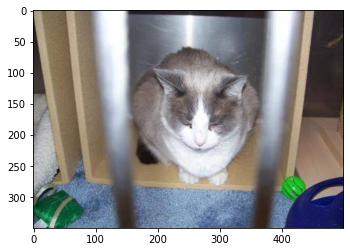

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
img_path = os.path.join(train_cats_dir, train_cat_fnames[0]) 
img = mpimg.imread(img_path)
plt.imshow(img)

In [ ]:
type(img), img.shape, img[0,0,:], img.max()  # 8-bits

(numpy.ndarray, (350, 499, 3), array([159, 139, 112], dtype=uint8), 255)

## 간단한 CNN을 사용한 모델


In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 

"""
keras에서는 이미지데이터 학습을 쉽게하도록 하기위해 다양한 패키지를 제공한다. 그 중 하나가 ImageDataGenerator 클래스이다. ImageDataGenerator 클래스를 통해 객체를 생성할 때 파라미터를 전달해주는 것을 통해 데이터의 전처리를 쉽게할 수 있고, 또 이 객체의 
flow_from_directory 메소드를 활용하면 폴더 형태로된 데이터 구조를 바로 가져와서 사용할 수 있다. 이 과정은 매우 직관적이고 코드도 ImageDataGenerator를 사용하지 않는 방법에 비해 상당히 짧아진다.

출처: https://3months.tistory.com/199 [Deep Play]
"""

#### ImageDataGenerator() object
- Generate batches of tensor image data with real-time data augmentation. The data 
  will be looped over (in batches).
- flow_from_dataframe() method: Takes the dataframe and the path to a directory and 
    generates batches of augmented/normalized data.
- flow_from_directory() method: Takes the path to a directory & generates batches of 
    augmented data.

In [6]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                      

In [ ]:
# for exercise (just for checking) - it will loop forever, so you need break !
for data_batch, labels_batch in train_generator:
    print(data_batch.shape, labels_batch.shape)
    break

(20, 150, 150, 3) (20,)


- .fit은 전체 학습 데이터 세트가 메모리에 맞고 data augmentation 을 사용하지 않을 경우.
- .fit_generator는 메모리에 맞출 거대한 데이터 세트가 있거나 data augmentation 을 사용할 경우.
  - The first argument is the **iterator** for the train images that we get from the flow() or flow_from_dataframe() or flow_from_directory() method.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


100/100 [==============================] - 19s 89ms/step - loss: 0.6914 - acc: 0.5260 - val_loss: 0.6707 - val_acc: 0.6110
Epoch 2/10
100/100 [==============================] - 9s 89ms/step - loss: 0.6604 - acc: 0.6110 - val_loss: 0.6360 - val_acc: 0.6680
Epoch 3/10
100/100 [==============================] - 9s 89ms/step - loss: 0.6150 - acc: 0.6670 - val_loss: 0.6150 - val_acc: 0.6570
Epoch 4/10
100/100 [==============================] - 9s 91ms/step - loss: 0.5673 - acc: 0.7155 - val_loss: 0.5785 - val_acc: 0.7060
Epoch 5/10
100/100 [==============================] - 9s 95ms/step - loss: 0.5316 - acc: 0.7240 - val_loss: 0.5576 - val_acc: 0.7210
Epoch 6/10
100/100 [==============================] - 9s 89ms/step - loss: 0.5093 - acc: 0.7465 - val_loss: 0.5497 - val_acc: 0.7080
Epoch 7/10
100/100 [==============================] - 9s 89ms/step - loss: 0.4744 - acc: 0.7740 - val_loss: 0.5417 - val_acc: 0.7210
Epoch 8/10
100/100 [==============================] - 9s 89ms/step - loss: 0.44

In [ ]:
model.save('./sample_data/cats_and_dogs_from_lab60.h5')  # will be used later in this code
# or tf.keras.models.save_model()
model = keras.models.load_model('./sample_data/cats_and_dogs_from_lab60.h5')

- there are two types for saving the models
  - tensorflow SavedModel (recommended)(default for model.save())
  - keras H5 (파일명을 '.h5' 로 주거나 parameter format='h5') 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#### When we call the .fit() function it makes assumptions:

- The entire training set can fit into the Random Access Memory (RAM) of the computer.
- Calling the model .fit method for a second time is not going to reinitialize our 
  already trained weights, which means we can actually make consecutive calls to fit 
  if we want to and then manage it properly.
- There is no need for using the Keras generators(i.e no data argumentation)
- Raw data is itself used for training our network and our raw data will only fit 
  into the memory.

#### When we call the .fit_generator() function it makes assumptions:

- generator 함수를 사용해야 함.
- Keras is first calling the generator function(dataAugmentaion)
- Generator function(dataAugmentaion) provides a batch_size of 32 to our .fit_generator() function.
- our .fit_generator() function first accepts a batch of the dataset, then performs 
  backpropagation on it, and then updates the weights in our model.
- For the number of epochs specified(10 in our case) the process is repeated.
- returns a History object. Its History.history attribute is a record of training 
  loss values and metrics values at successive epochs, as well as validation loss 
  values and validation metrics values (if applicable).

## 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

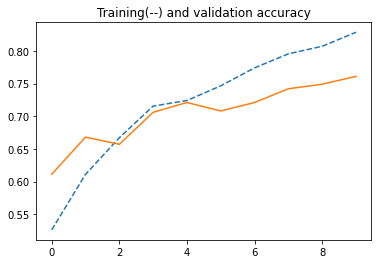

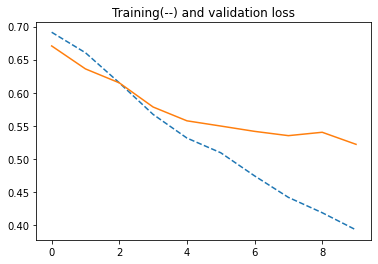

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')


### 과대적합이 발생한 것을 알 수 있다.
- 모델은 복잡한데 적은 수의 데이터를 반복 (이포크) 사용하여 훈련시킨 때문으로 보임.



# Data augmentation and Dropout
- 드롭 아웃 계층은 훈련 시간 동안 각 단계의 rate 를 사용하여 입력 단위를 무작위로 0으로 설정하여 ovefitting 을 방지.
- 0 으로 설정되지 않은 입력은 모든 입력에 대한 합계가 변경되지 않도록 1 / (1-rate)만큼 scaled up.
- training 할 때만 적용되고 inference 할 때에는 drop 되지 않음.

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)


model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### augmented 된 훈련 이미지는 마지막 셀에서 보세요...^^

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


100/100 [==============================] - 18s 173ms/step - loss: 0.6896 - acc: 0.5350 - val_loss: 0.6810 - val_acc: 0.5740
Epoch 2/30
100/100 [==============================] - 18s 176ms/step - loss: 0.6800 - acc: 0.5640 - val_loss: 0.6522 - val_acc: 0.6120
Epoch 3/30
100/100 [==============================] - 17s 173ms/step - loss: 0.6656 - acc: 0.5795 - val_loss: 0.6405 - val_acc: 0.6200
Epoch 4/30
100/100 [==============================] - 17s 173ms/step - loss: 0.6522 - acc: 0.6075 - val_loss: 0.6206 - val_acc: 0.6440
Epoch 5/30
100/100 [==============================] - 17s 174ms/step - loss: 0.6378 - acc: 0.6230 - val_loss: 0.5948 - val_acc: 0.6770
Epoch 6/30
100/100 [==============================] - 17s 174ms/step - loss: 0.6311 - acc: 0.6370 - val_loss: 0.6033 - val_acc: 0.6640
Epoch 7/30
100/100 [==============================] - 17s 174ms/step - loss: 0.6079 - acc: 0.6595 - val_loss: 0.5695 - val_acc: 0.6990
Epoch 8/30
100/100 [==============================] - 18s 182ms/st

Text(0.5, 1.0, 'Training(--) and validation loss')

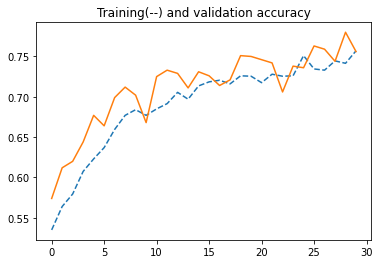

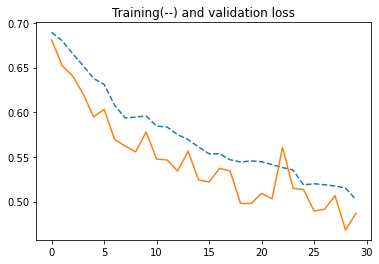

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않음을 볼 수 있다.

In [ ]:
model.save('cats_and_dogs_from_lab60_augmented.h5') 

In [8]:
model = keras.models.load_model('cats_and_dogs_from_lab60_augmented.h5')

# TTA (Test Time Augmentation)
- simply apply different transformations to test image like: rotations, flipping and translations
- Then feed these different transformed images to the trained model and average the results to get more confident answer.
- it doesn't always guarantee better performance.

## Performance for train and validation data

In [10]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)                                  # augmented

validation_datagen = ImageDataGenerator(rescale = 1./255)  # un-augmented

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# perf for train set (augmented)
loss, acc = model.evaluate(train_generator)
print (acc)

100/100 [==============================] - 21s 135ms/step - loss: 0.4880 - acc: 0.7675
0.7674999833106995


In [12]:
# performance for validation set (no augment)
loss, acc = model.evaluate(validation_generator)
print (acc)

50/50 [==============================] - 3s 58ms/step - loss: 0.4871 - acc: 0.7560
0.7559999823570251


In [13]:
# performance for (unaugmented) train set

train_generator_unaug = validation_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   shuffle=False,
											   batch_size=20)
loss, acc = model.evaluate(train_generator_unaug)
print (acc)

Found 2000 images belonging to 2 classes.
100/100 [==============================] - 6s 62ms/step - loss: 0.4394 - acc: 0.7880
0.7879999876022339


## Just to see how ImageDataGenerator works

In [ ]:
## just for reference to see output of the generators
img_iter = train_generator

for i in range(3):
    z = next(img_iter)

len(z), z[0].shape, z[1].shape   # input image (z[0]) and label (z[1])
                                 # batch_size = 20

(2, (20, 150, 150, 3), (20,))

In [ ]:
z[1]

array([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 1.], dtype=float32)

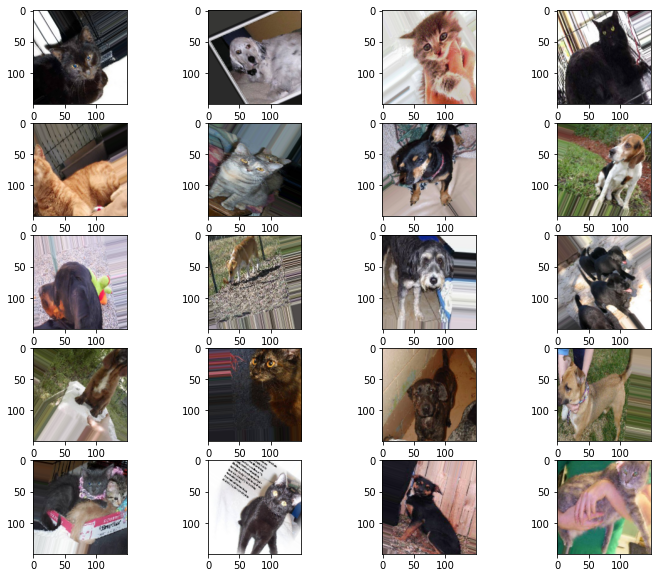

[0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.]


In [ ]:
# to see augmented train images

z = next(train_generator)       # first batch

plt.figure(figsize=(12,10))

for i in range(20):
    plt.subplot(5,4,i+1)
    imgplot = plt.imshow(image.array_to_img(z[0][i]))
    i +=1
plt.show()
print(z[1])

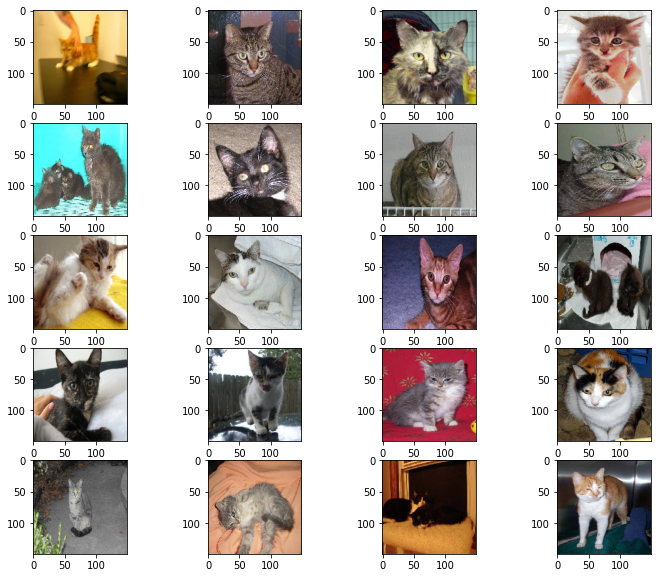

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# to see un-augmented train images

z = next(train_generator_unaug)  # first batch

plt.figure(figsize=(12,10))

for i in range(20):
    plt.subplot(5,4,i+1)
    imgplot = plt.imshow(image.array_to_img(z[0][i]))
    i +=1
plt.show()
print(z[1])

In [ ]:
model.predict(z[0])

array([[0.73114187],
       [0.21070158],
       [0.5889975 ],
       [0.81871706],
       [0.11431237],
       [0.5078791 ],
       [0.04779487],
       [0.06131385],
       [0.18389453],
       [0.11985752],
       [0.86245996],
       [0.35130364],
       [0.125569  ],
       [0.37698704],
       [0.06233992],
       [0.27193215],
       [0.20511316],
       [0.31705675],
       [0.18205112],
       [0.70345765]], dtype=float32)

In [ ]:
(model.predict(z[0]) >= 0.5).astype(int).ravel()

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
((model.predict(z[0]) >= 0.5).astype(int).ravel() == z[1]).mean()

0.7

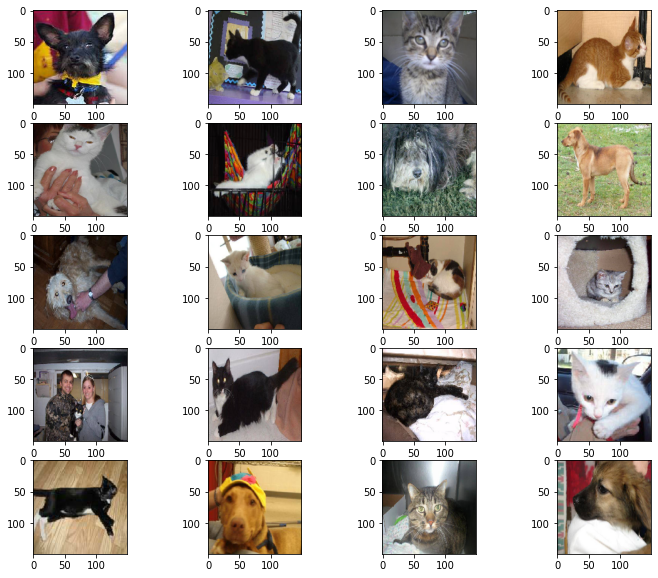

[1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]


In [ ]:
# to see (unaugmented) validation images

z = next(validation_generator)  # first batch

plt.figure(figsize=(12,10))

for i in range(20):
    plt.subplot(5,4,i+1)
    imgplot = plt.imshow(image.array_to_img(z[0][i]))
    i +=1
plt.show()
print(z[1])

In [ ]:
((model.predict(z[0]) >= 0.5).astype(int).ravel() == z[1]).mean()

0.8

## Let's take performance test (without using model.evaluate() function)
- unaugmented train images
- unaugmented validation images
- (augmented) validation images

In [ ]:
# performance for (unaugmented) train images
from tqdm import tqdm

trues, preds = [], []
for i in tqdm(range(100)):
    z = next(train_generator_unaug)
    true = z[1]
    pred = (model.predict(z[0]) >= 0.5).astype(float).ravel()
    trues.extend(true)
    preds.extend(pred)

print("accuracy for (augmented) train data: ", np.mean(np.array(trues) == np.array(preds)))

In [ ]:
# performance for validation images
trues, preds = [], []
for i in tqdm(range(50)):
    z = next(validation_generator)
    true = z[1]
    pred = (model.predict(z[0]) >= 0.5).astype(float).ravel()
    trues.extend(true)
    preds.extend(pred)

print("accuracy for validation data: ", np.mean(np.array(trues) == np.array(preds)))

- we got the same result as the function model.evaluate()

## Let's use augmentation on the validation data
- ImageDataGenerator()
  - shuffle=False 로 주면 data shuffling 이 안됨. transform 은 random.
  - seed 를 주면 suffling and transform 이 seed 로 시작해서 randomize 됨.

In [18]:
validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											                 target_size=(img_width,img_height),
											                 class_mode='binary',
											                 shuffle=False,           ###
											                 batch_size=20)
validation_generator_aug = train_datagen.flow_from_directory(directory=validation_dir,
											                 target_size=(img_width,img_height),
											                 class_mode='binary',
											                 shuffle=False,           ###
											                 batch_size=20)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
for i in range(50):
    z = next(validation_generator_aug)
    if i%1 == 0:
        print(z[0].shape, z[1])


(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(20, 150, 150, 3) [0. 0. 0. 0. 0. 0. 0. 

In [26]:
# without original images (only with augmented images)
# - 10 augmented images per one validation image

tta_step = 10
trues_10, preds_10 = [], []

for i in tqdm(range(tta_step)):

    trues, preds = [], []
    for i in range(50):
        z = next(validation_generator_aug)      # z[0]: x-data, z[1]: y-data
        true, pred = z[1], model.predict(z[0], verbose=0).ravel()
        trues.extend(true)
        preds.extend(pred)
    trues_10.append(trues)
    preds_10.append(preds)    

print(np.array(trues_10).shape, np.array(preds_10).shape)  # (10,1000)

acc = ((np.array(preds_10).mean(axis=0) >= 0.5).astype(float) == np.array(trues_10).mean(axis=0)).mean()
print("Accuracy for augmented validation data: ", acc)

100%|██████████| 10/10 [01:33<00:00,  9.32s/it]

(10, 1000) (10, 1000)
Accuracy for augmented validation data:  0.737


In [23]:
np.array(trues_10).mean()

0.5

In [24]:
# original images only
trues_org, preds_org = [], []
for i in tqdm(range(50)):
        z = next(validation_generator)      # z[0]: x-data, z[1]: y-data
        true, pred = z[1], model.predict(z[0], verbose=0).ravel()
        trues_org.extend(true)
        preds_org.extend(pred)

acc = ((np.array(preds_org) >= 0.5).astype(float) == np.array(trues_org)).mean()
print("Accuracy for original validation images only: ", acc)

100%|██████████| 50/50 [00:05<00:00,  9.54it/s]

Accuracy for original validation images only:  0.756


In [25]:
np.array(trues_org).mean()

0.5

In [27]:
# original validation images with augmented images
p = np.concatenate([np.array(preds_10), np.array(preds_org).reshape(1,-1)])
t = np.concatenate([np.array(trues_10), np.array(trues_org).reshape(1,-1)])
print(t.shape, p.shape)

acc = ((p.mean(axis=0) >= 0.5) == (t.mean(axis=0) >= 0.5)).mean()
print("Accuracy for original and augmented images: ", acc)

(11, 1000) (11, 1000)
Accuracy for original and augmented images:  0.744


- Here, we did not get peformance increase. TTA doesn't always give better performance.
- Finding the Best Augmentation Parameters for TTA
  - 1. Optimize augmentation parameters sparately
  - 2. Find the best combination of N augmented images
  - 3. Combine multiple augmentation parameters
- for more in details, see https://stepup.ai/test_time_data_augmentation/

# Random 하게 데이터 증식한 훈련 이미지 그리기 (from the Keras book)


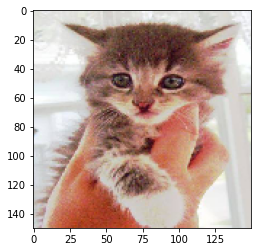

In [ ]:
from keras.preprocessing import image   # 이미지 전처리 유틸리티 모듈

fnames = sorted([os.path.join(train_cats_dir, fname) for 
                fname in os.listdir(train_cats_dir)])
img_path = fnames[3]  # 증식할 이미지 선택
img = image.load_img(img_path, target_size=(150,150)) # 이미지를 읽고 크기 변경

plt.imshow(img)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True)

In [ ]:
# ImageDataGenerator.flow(): Takes data & label arrays, generates batches of augmented data.
# 배치 데이터를 기대하기 떄문에 샘플 데이터에 배치 차원을 추가하여 4-d 텐서로 만듬.

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)    # (1,150,150,3) 크기로 변환
print(x.shape)

(1, 150, 150, 3)


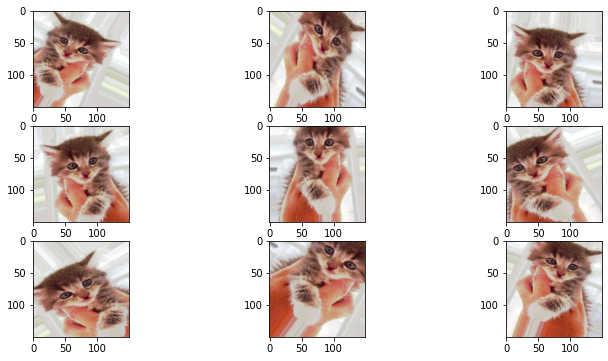

In [ ]:
i = 0
plt.figure(figsize=(12,6))
for batch in train_datagen.flow(x, batch_size=1):   # endless loop (need break)
    plt.subplot(3,3,i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i +=1
    if i % 9 == 0:
        break
plt.show()

# For your reference

In [ ]:
a = np.array([[1,2],[3,4]])
print(a.shape)
print(a.reshape(4,1))
print((1,) + a.shape)
(1,4) + (2,3)   # tuple concatenation

(2, 2)
[[1]
 [2]
 [3]
 [4]]
(1, 2, 2)


(1, 4, 2, 3)

(9, 1, 28, 28)


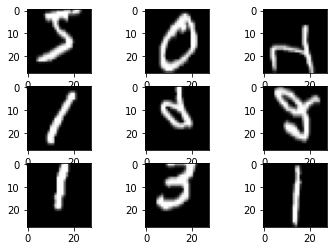

[5 0 4 1 9 2 1 3 1]


In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],1,28,28).astype('float32')
datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

# datagen.fit(X_train)
batch_size=9

# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size, seed=42): # seed for shuffling and random transformation
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=False) :
    print(X_batch.shape)
    for i in range(batch_size):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.show()
    print(y_batch)
    break

# Visualizing Filters
- refer to lab61

# Visualizing Convnet Training 
- from Deep Learning with Python, by Francois Chollet
- 딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./sample_data/cats_and_dogs_from_lab60.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

(1, 150, 150, 3) <class 'numpy.ndarray'>


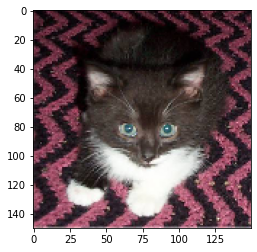

In [ ]:
img_path = './cats_and_dogs_filtered/train/cats/cat.46.jpg'


from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)   # image 를 4D 텐서로
img_tensor /= 255.
print(img_tensor.shape, type(img_tensor))
# plotting the image
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 층의 활성화마다 하나씩 8개의 numpy 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

In [ ]:
len(activations)

8

In [ ]:
[activations[i].shape for i in range(8)]

[(1, 148, 148, 32),
 (1, 74, 74, 32),
 (1, 72, 72, 64),
 (1, 36, 36, 64),
 (1, 34, 34, 128),
 (1, 17, 17, 128),
 (1, 15, 15, 128),
 (1, 7, 7, 128)]

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


- 32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 스무 번째 채널을 그려 보겠습니다:

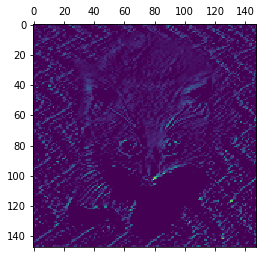

In [ ]:
# Matplotlib matshow is a wrapper for imshow , in that it "sets origin to 'upper', 
# 'interpolation' to 'nearest' and 'aspect' to equal." So while matshow always uses 
# interpolation="nearest" , imshow by default has interpolation=None .
plt.matshow(first_layer_activation[0, :, :, 7], 
            cmap='viridis')                      # Display an array as a matrix 
                                                 # in a new figure window.
plt.show()

- 대각선 에지를 표현하는 인코딩 정도로 보임

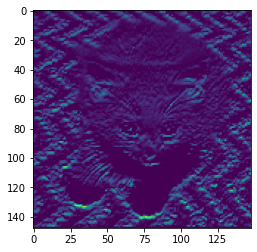

In [ ]:
plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

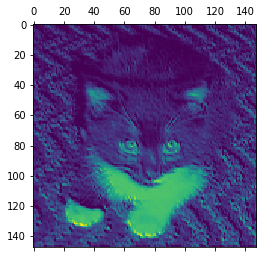

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

- 밝은 부분?

In [ ]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

- 몇 가지 주목할 내용이 있습니다:
  - 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됨을 볼 수 있다.
  - 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워진다. '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작한다. 
  - 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가한다.
  - 비어 있는 활성화가 층이 깊어짐에 따라 늘어난다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생긴다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미한다.

# Exercise

## ImageDataGenerator for augmentation
- accepts an original data batch, randomly transforms it, and returns only the new, transformed data. (**excluding** the original one) - called in-place data augentation
- applying simple geometric transforms (translation, rotation , scaling, shearing, flipping)

In [ ]:
datagen = ImageDataGenerator(
                  rotation_range=10,          # rotation
                  width_shift_range=0.2,      # horizontal shift
                  height_shift_range=0.2,     # vertical shift
                  zoom_range=0.2,             # zoom
                  horizontal_flip=True,       # horizontal flip
                  brightness_range=[0.2,1.2]) # brightness

train_generator = datagen.flow_from_directory(
                  directory=train_dir,
                  target_size=(150, 150),     # resize to this size
                  color_mode="rgb",           # for coloured images
                  batch_size=5,               # number of images to extract from folder for every batch
                  class_mode="binary",        # classes to predict
                  seed=42                     # to make the result reproducible
                  )

NameError: ignored

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

In [ ]:
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

### array clipping

In [ ]:
a = np.arange(-5, 5)
print(a)
np.clip(a, 0, 3)

[-5 -4 -3 -2 -1  0  1  2  3  4]


array([0, 0, 0, 0, 0, 0, 1, 2, 3, 3])